In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import coronavirus as cv
from coronavirus import *

configure_matplotlib()

In [24]:
ts = load_timeseries()

In [25]:
IRL = location('IRL')
IRL

,date,city,county,state,country_code,population,lat,long,url,cases,deaths,recovered,active,tested,growthFactor,country,location,cases/deaths,cases/100k,1d new recovered,1d new deaths,1d new cases,1d new active,3d new recovered,3d new deaths,3d new cases,3d new active,7d new recovered,7d new deaths,7d new cases,7d new active,days since 75 cases,days since 75 active,days since 1 case/100k people
0,2020-01-22,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-51.0,-51.0,-51.0
1,2020-01-23,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-50.0,-50.0,-50.0
2,2020-01-24,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-49.0,-49.0,-49.0
3,2020-01-25,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-48.0,-48.0,-48.0
4,2020-01-26,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-47.0,-47.0,-47.0
5,2020-01-27,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-46.0,-46.0,-46.0
6,2020-01-28,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-45.0,-45.0,-45.0
7,2020-01-29,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-44.0,-44.0,-44.0
8,2020-01-30,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-43.0,-43.0,-43.0
9,2020-01-31,<NA>,<NA>,<NA>,IRL,"5,011,102.0",53.5,-8.1,https://github.com/CSSEGISandData/COVID-19,NaN,NaN,NaN,NaN,NaN,<NA>,Ireland,IRL,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,-42.0,-42.0,-42.0


----
# Today Query

In [28]:
today_locs = ['USA', 'CAN', 'IRL', 'ITA', 'ESP', 'British Columbia, CAN', 'NY, USA', 'WA, USA']
today_cols = ['date', 'location', 'cases', 'deaths']

cur_day = np.datetime64('today') - np.timedelta64(1, 'D')
prev_day = np.datetime64('today') - np.timedelta64(2, 'D')

today_query = ts.location.isin(today_locs)
today_query &= ts.date.isin([cur_day, prev_day])

todaytable = ts[today_query][today_cols]
todaytable.date = todaytable.date.astype(str).str[:10]
cur_day = str(cur_day)[:10]
prev_day = str(prev_day)[:10]

def today_summary(value):
    table = todaytable.pivot(index='location', columns='date', values='cases')
    table['delta'] = table[cur_day] - table[prev_day]
    table = table.sort_values(by=cur_day, ascending=False)
    return table.style.format({cur_day: '{:,.0f}', prev_day: '{:,.0f}', 'delta': '{:+,.0f}'})

----
# Cases

In [29]:
today_summary('cases')

date,2020-03-23,2020-03-24,delta
location,,,
ITA,"63,927","69,176","+5,249"
USA,"42,164","53,192","+11,028"
ESP,"32,796","39,673","+6,877"
"NY, USA","20,875","25,665","+4,790"
"WA, USA","1,996","2,469",+473
CAN,"1,646","1,959",+313
IRL,906,"1,329",+423
"British Columbia, CAN",472,617,+145


----
# Deaths

In [30]:
today_summary('deaths')

date,2020-03-23,2020-03-24,delta
location,,,
ITA,"63,927","69,176","+5,249"
USA,"42,164","53,192","+11,028"
ESP,"32,796","39,673","+6,877"
"NY, USA","20,875","25,665","+4,790"
"WA, USA","1,996","2,469",+473
CAN,"1,646","1,959",+313
IRL,906,"1,329",+423
"British Columbia, CAN",472,617,+145


----
# Locations of Interest

In [21]:
locations_of_interest = {
    'WA':    ('WA, USA',          'teal'),
    'BC':    ('British Columbia', 'slateblue'),
    'Italy': ('Italy',            'chocolate'),
    'NY':    ('NY, USA',          'tomato'),
    'UK':    ('UK',               'royalblue'),
    'FL':    ('FL, USA',          'darkorange'),
    'IRL':   ('Ireland',          'forestgreen'),
    'Spain': ('Spain',            'goldenrod')
}
tables_interest = { k:location(loc) for k, (loc, _) in locations_of_interest.items() }
cv.loc_colors = {k:col for k, (_, col) in locations_of_interest.items() }

hotspots = ['Italy', 'Spain', 'UK', 'NY', 'FL']
nearspots = ['BC', 'WA', 'IRL']

tables_hot = { loc:tables_interest[loc] for loc in hotspots }
tables_near = { loc:tables_interest[loc] for loc in nearspots }

----
# Locations of Interest
## Days Since 75 Cases

<IPython.core.display.Javascript object>


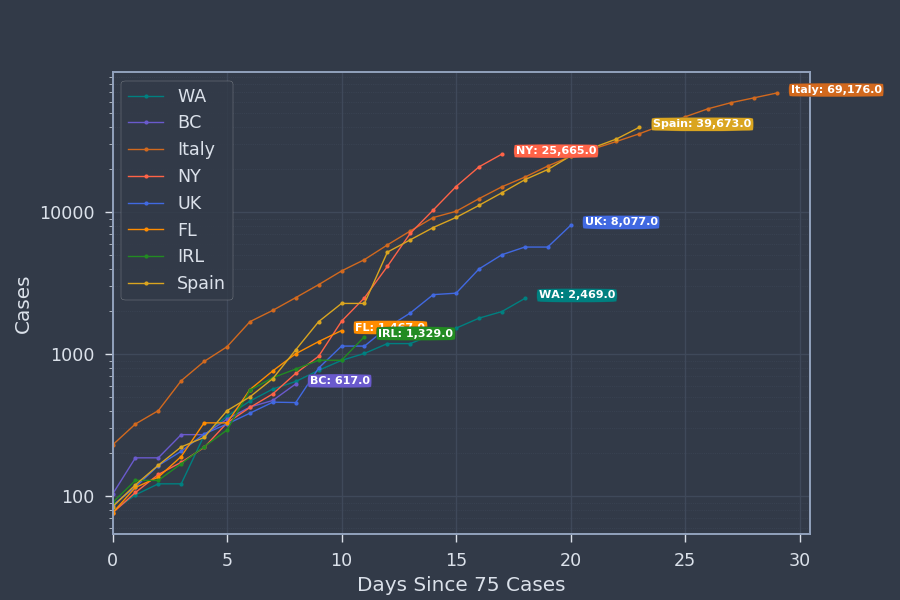

<IPython.core.display.Javascript object>


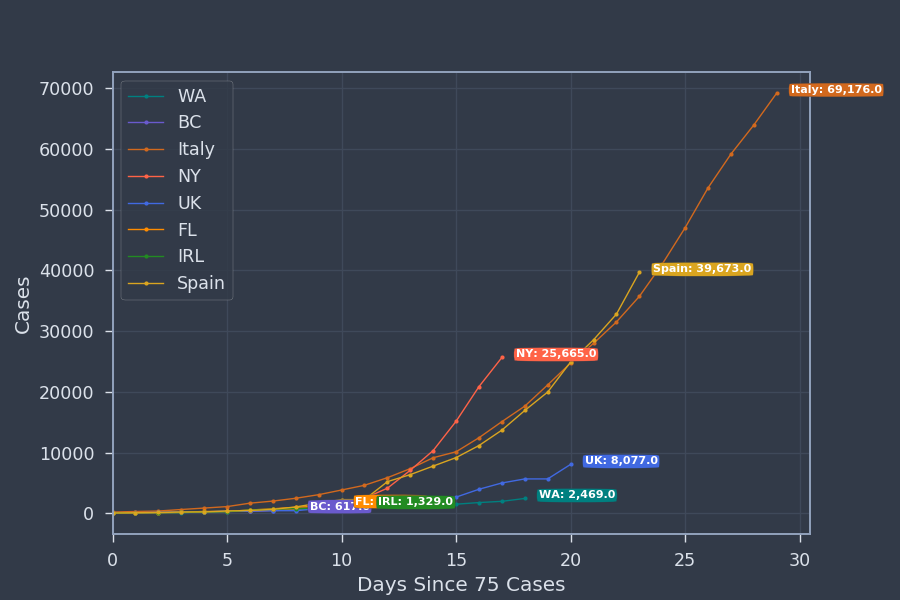

In [8]:
CovPlot75(tables_interest)
CovPlot75(tables_interest, scale='linear')

----
# Hotspots
## Days Since 75 Cases

<IPython.core.display.Javascript object>


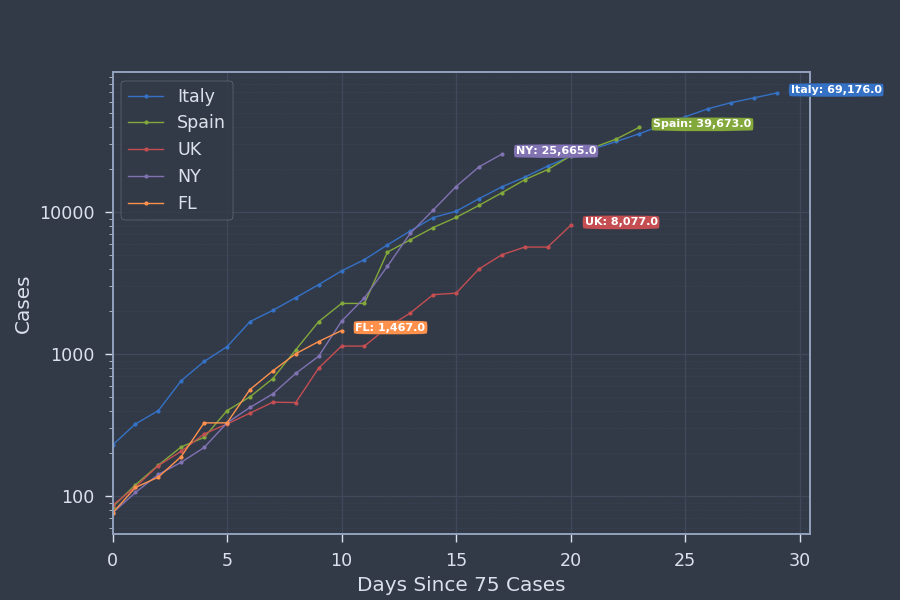

<IPython.core.display.Javascript object>


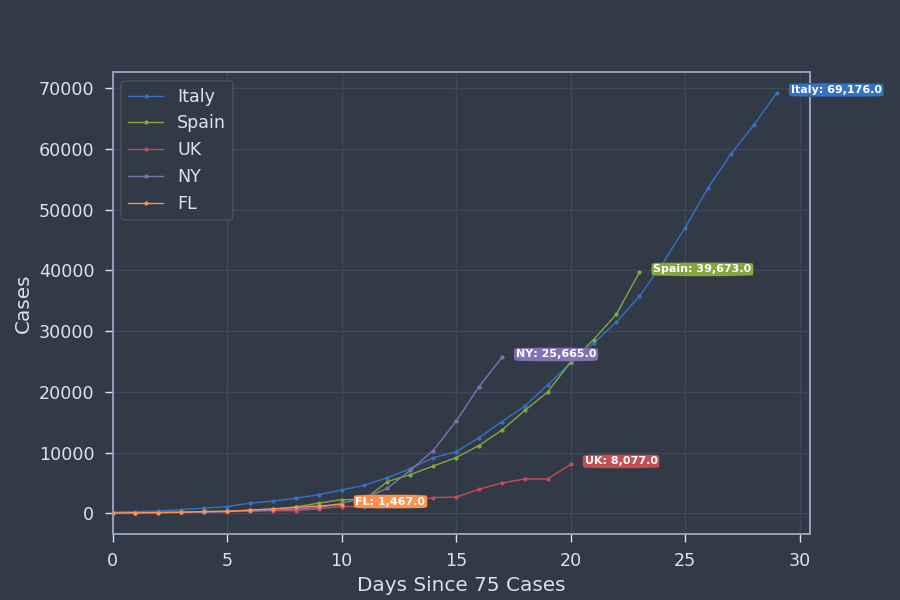

In [32]:
CovPlot75(tables_hot)
CovPlot75(tables_hot, scale='linear')

----
# Closely Tracked Spots
## Days Since 75 Cases

<IPython.core.display.Javascript object>


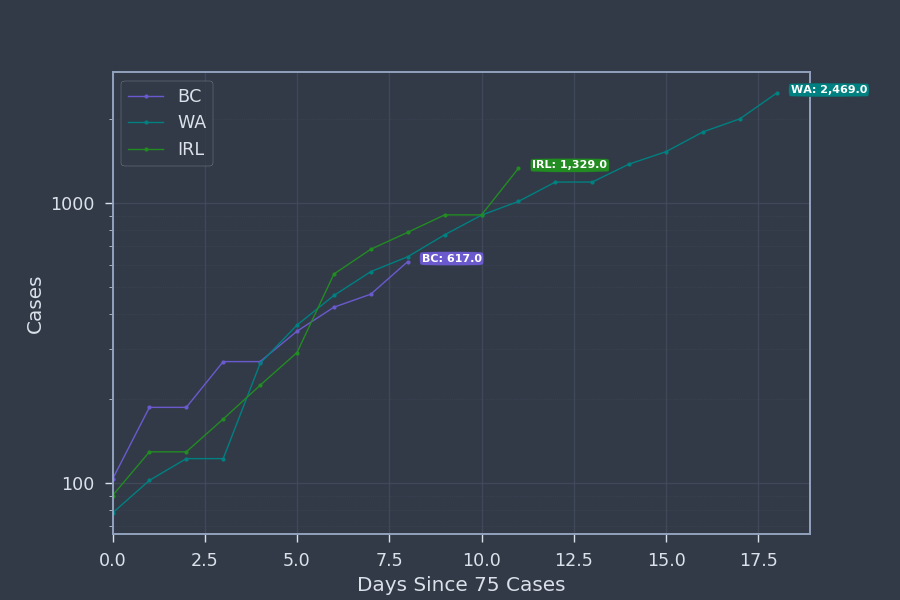

<IPython.core.display.Javascript object>


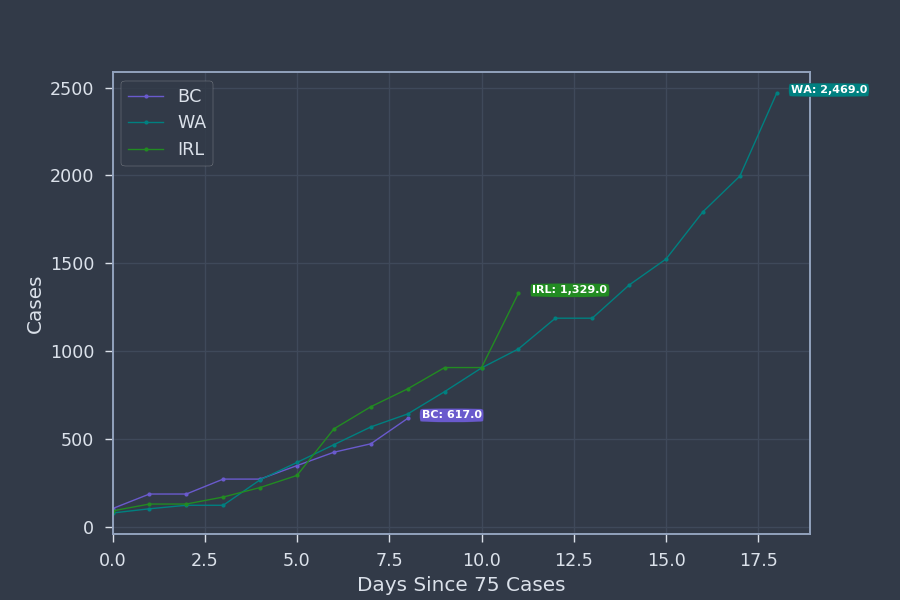

In [10]:
CovPlot75(tables_near)
CovPlot75(tables_near, scale='linear')

----
# Locations of Interest
## Date Plot

<IPython.core.display.Javascript object>


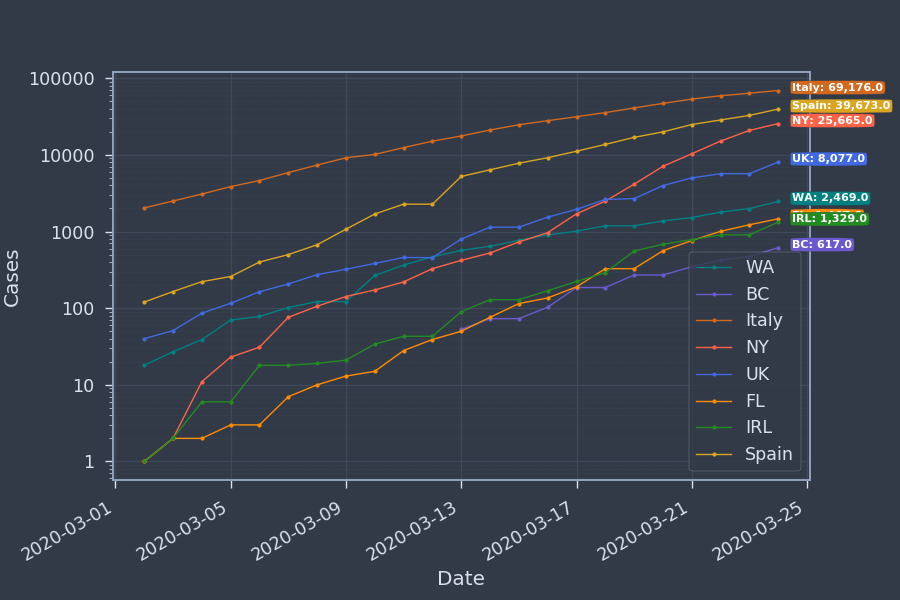

<IPython.core.display.Javascript object>


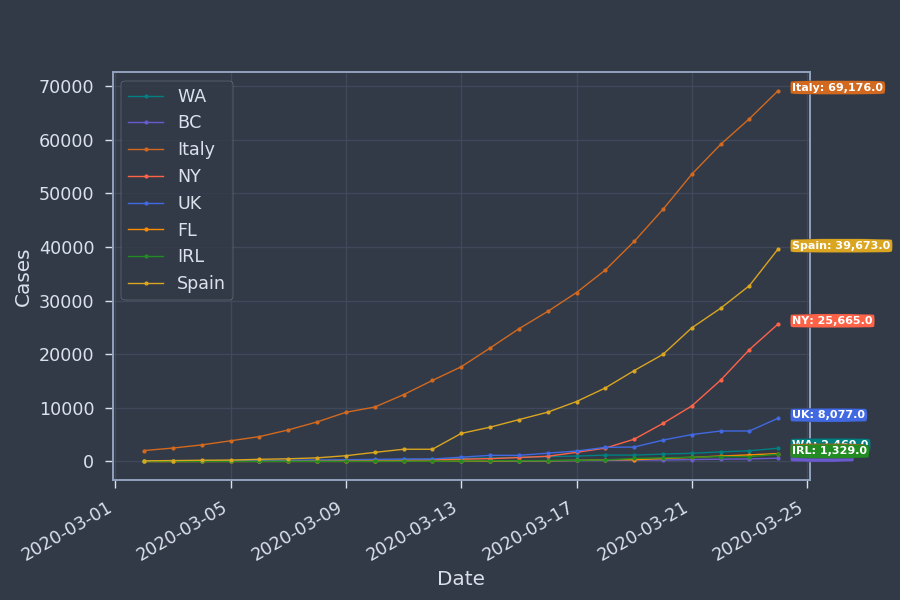

In [11]:
CovPlot(tables_interest)
CovPlot(tables_interest, scale='linear')

----
# Hotspots
## Date Plot

<IPython.core.display.Javascript object>


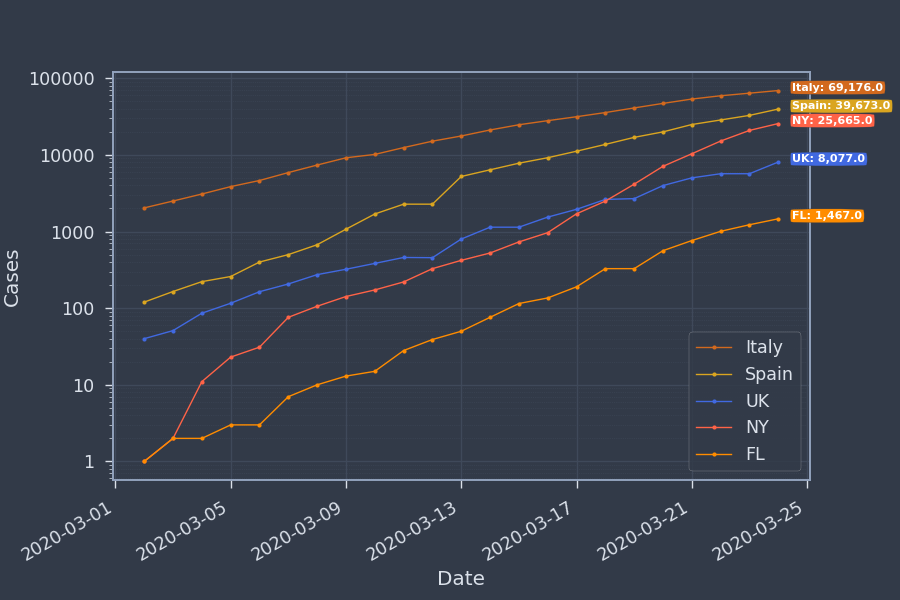

<IPython.core.display.Javascript object>


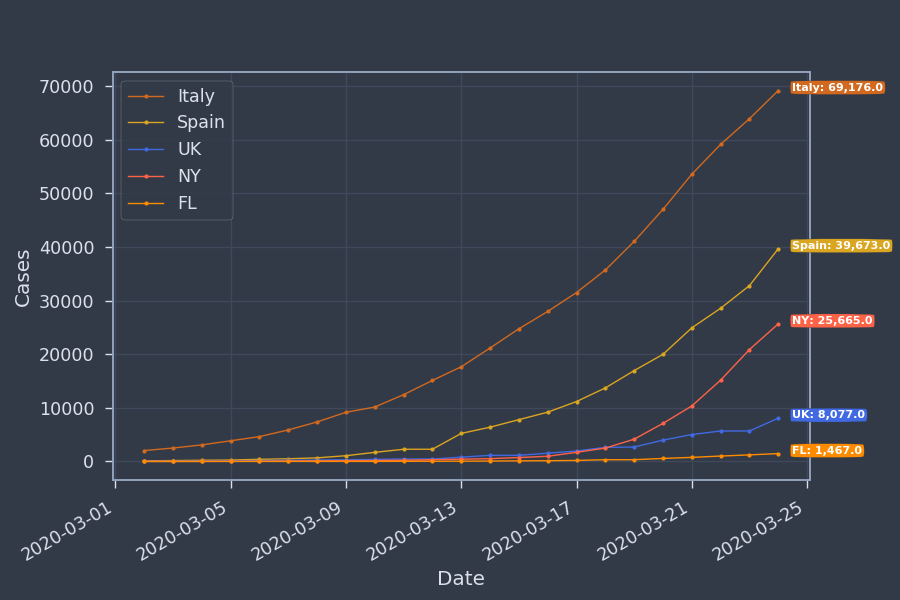

In [12]:
CovPlot(tables_hot)
CovPlot(tables_hot, scale='linear')

----
# Closely Tracked Spots
## Date Plot

<IPython.core.display.Javascript object>


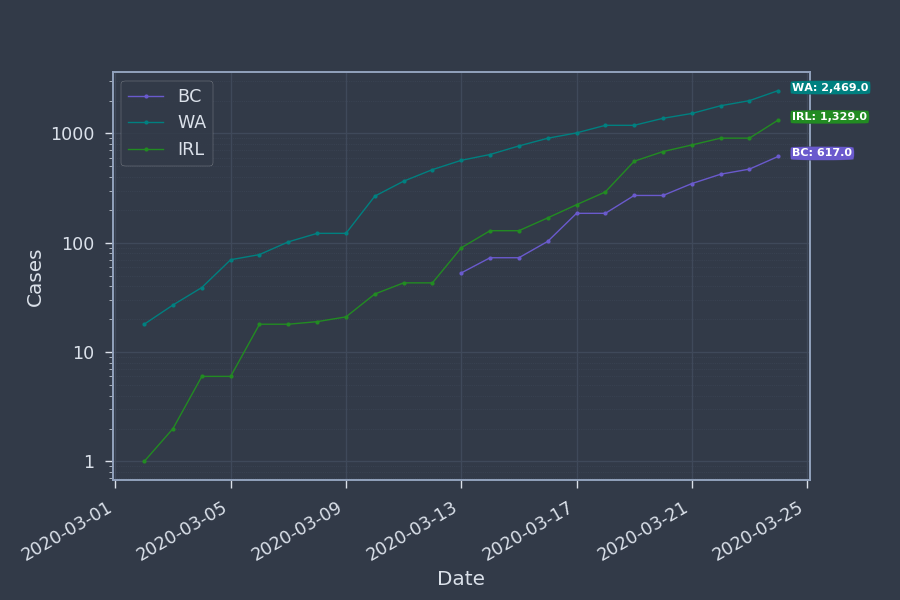

<IPython.core.display.Javascript object>


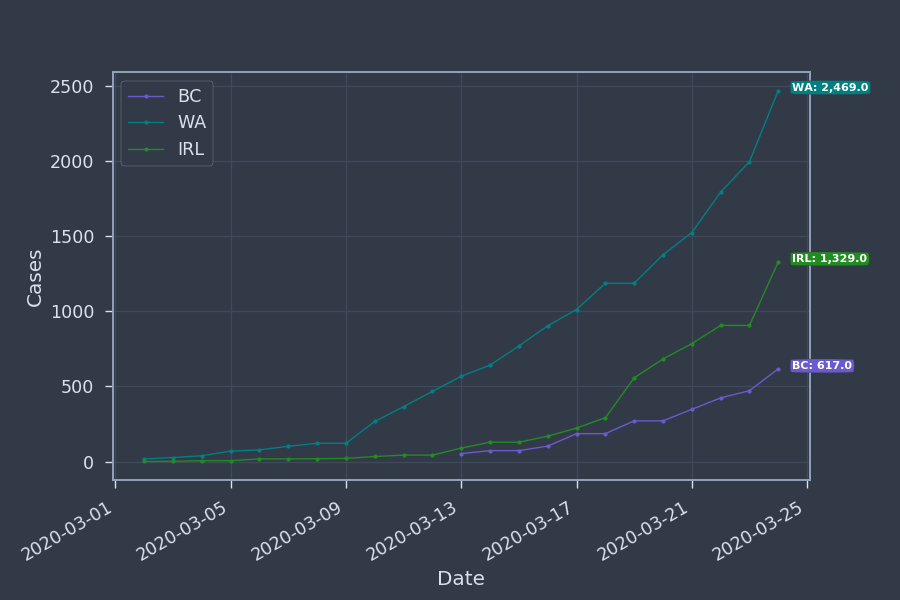

In [13]:
CovPlot(tables_near)
CovPlot(tables_near, scale='linear')

----
# Canadian Provinces

In [14]:
province_locs = {
    ('AB', 'Alberta, CAN'),
    ('BC', 'British Columbia, CAN'),
    ('MB', 'Manitoba, CAN'),
    ('NB', 'New Brunswick, CAN'),
    ('SK', 'Saskatchewan, CAN'),
    ('NS', 'Nova Scotia, CAN'),
    ('ON', 'Ontario, CAN'),
    ('QC', 'Quebec, CAN'),
}
provinces = { key:location(loc) for (key,loc) in province_locs }

----
# Canadian Provinces
## Date Plot

<IPython.core.display.Javascript object>


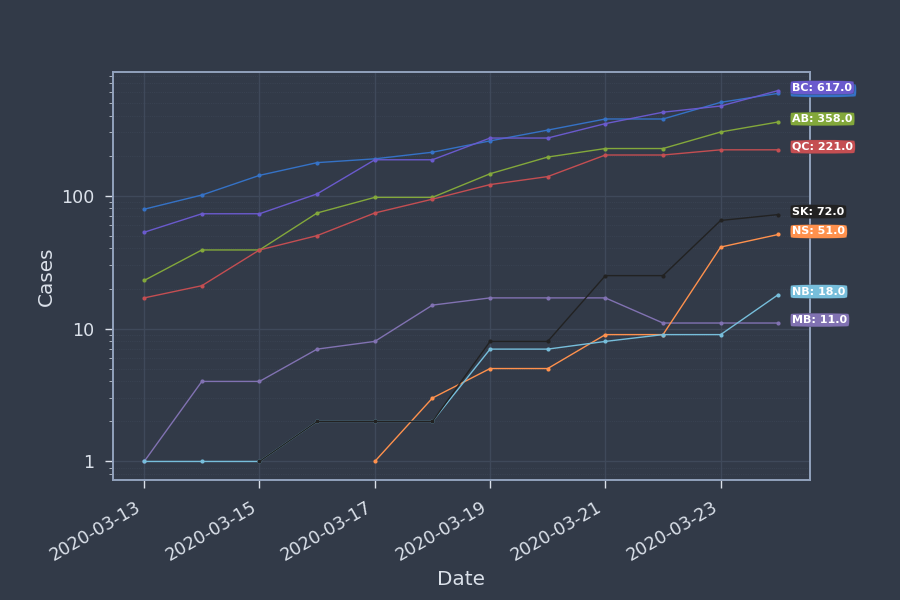

<IPython.core.display.Javascript object>


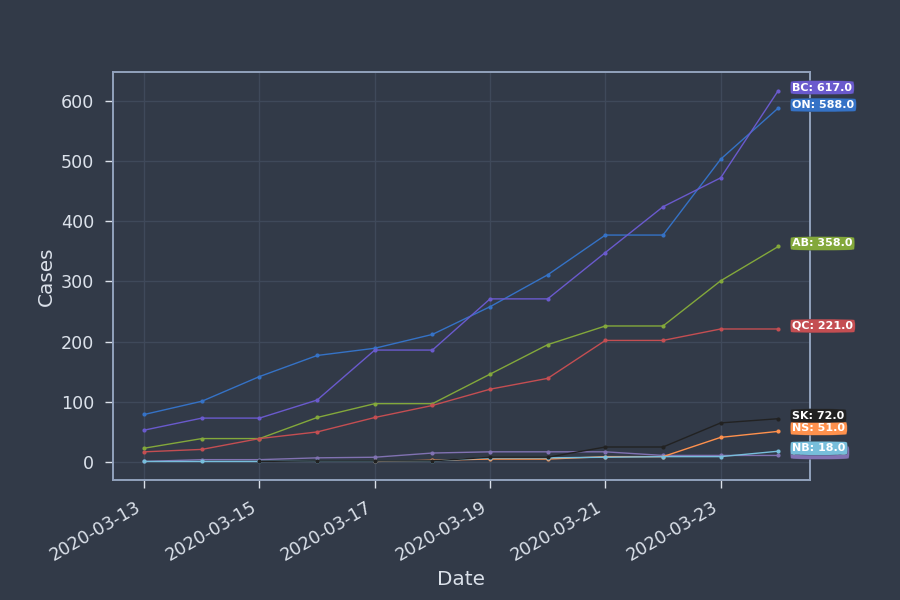

In [15]:
CovPlot(provinces, legend=False)
CovPlot(provinces, scale='linear', legend=False)

----
# Canadian Provinces
## Days Since 75 Cases

<IPython.core.display.Javascript object>


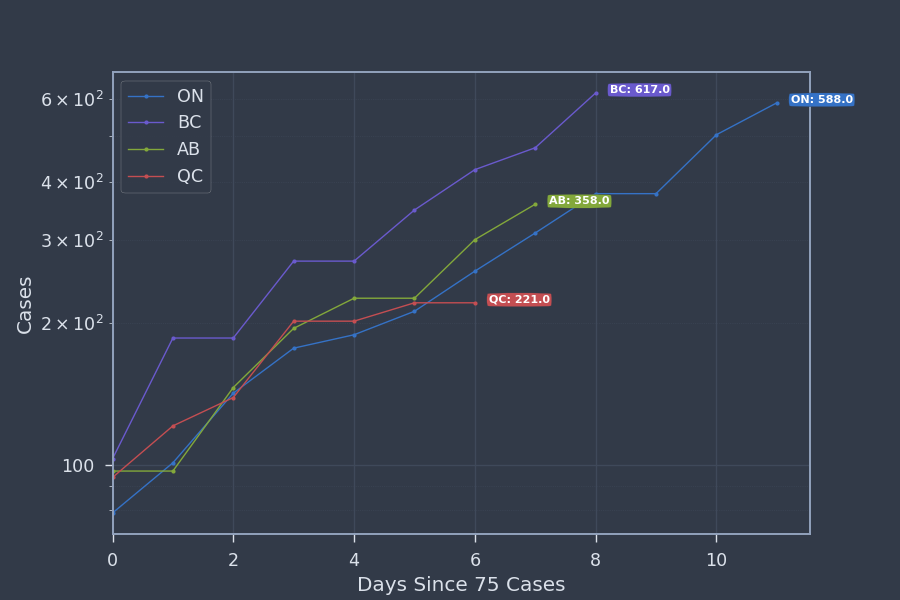

<IPython.core.display.Javascript object>


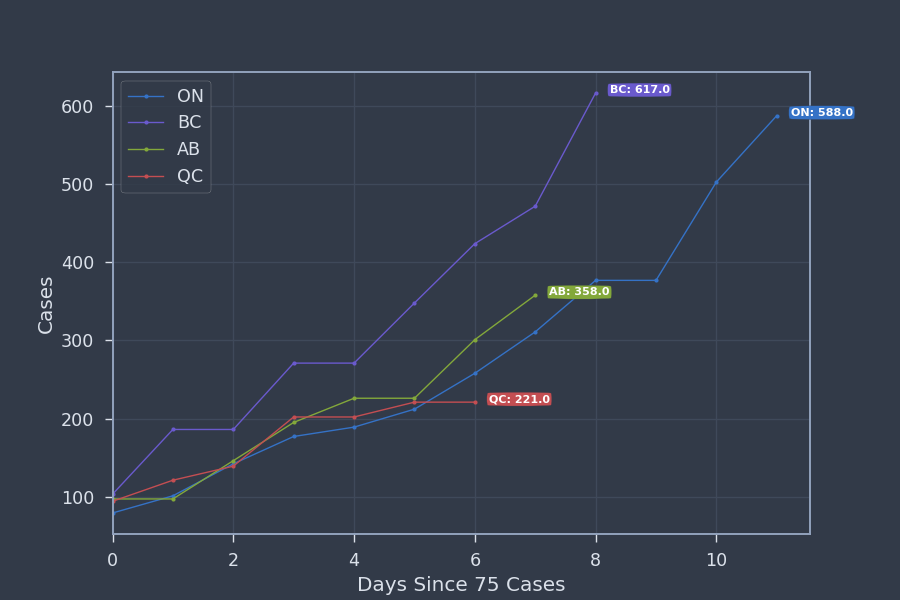

In [16]:
CovPlot75(provinces, legend=False)
CovPlot75(provinces, scale='linear', legend=False)

----
# New York vs Lombardy

In [17]:
ny_vs_lom = {
    'New York': location('NY, USA'),
    'Lombardy': location('Lombardia, ITA'),
}

----
# New York vs Lombary
## Days Since 75 Cases

<IPython.core.display.Javascript object>


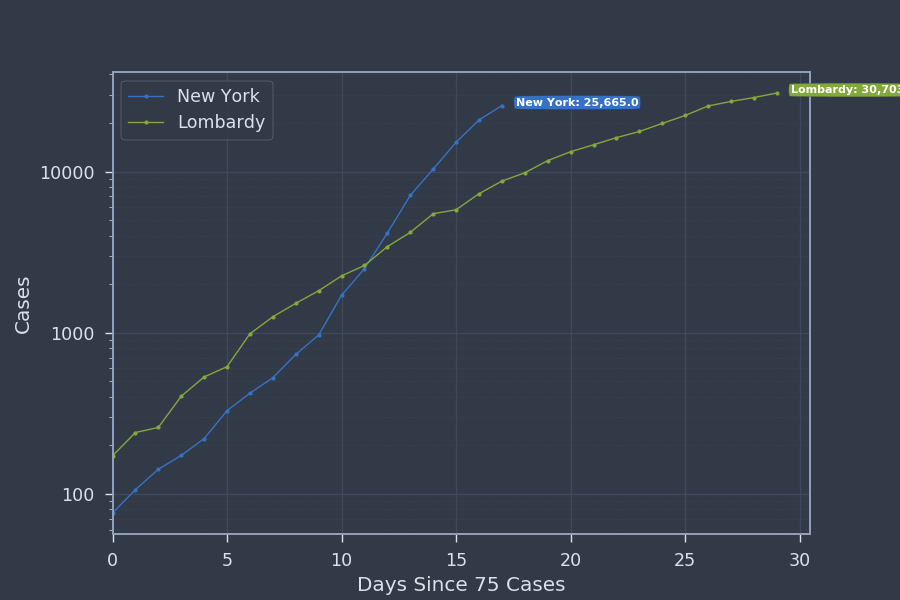

<IPython.core.display.Javascript object>


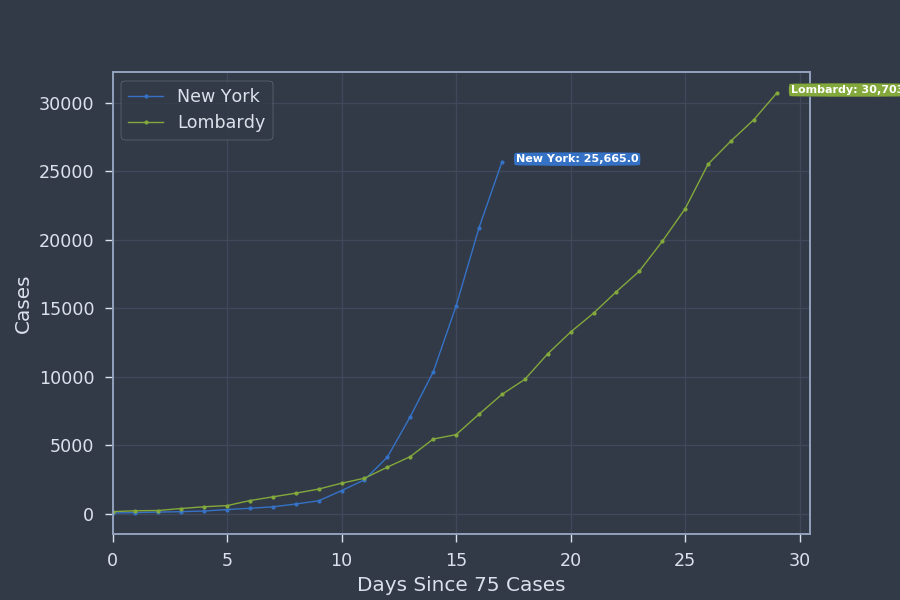

In [18]:
CovPlot75(ny_vs_lom)
CovPlot75(ny_vs_lom, scale='linear')